# Imgage segmentation by U-Net
Here, we use image segmentation by U-Net for self-driving cars. Please also see the original [U-Net article](https://arxiv.org/abs/1505.04597) by Ronneberger et al., "U-Net: Convolutional Networks for Biomedical Image Segmentation."

# <span style="color:green"> DATA </span>
The data includes RGB images and the corresponding masks. The goal is accurately preict the mask of each image.

In [89]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import matplotlib.pyplot as plt

In [90]:
image_path = 'data/CameraRGB/'
mask_path = 'data/CameraMask/'
image_list_orig = os.listdir(image_path)
image_list = [image_path+i for i in image_list_orig]
mask_list = [mask_path+i for i in image_list_orig]
print(f"sample image files:\n{image_list[:3]}")
print(f"corresponding masks:\n{mask_list[:3]}")

sample image files:
['data/CameraRGB/007788.png', 'data/CameraRGB/049764.png', 'data/CameraRGB/010604.png']
corresponding masks:
['data/CameraMask/007788.png', 'data/CameraMask/049764.png', 'data/CameraMask/010604.png']


## Store data in a tf.data.Dataset

In [91]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))
print(f"Sample dataset entry:")
print(next(iter(dataset)))

Sample dataset entry:
(<tf.Tensor: shape=(), dtype=string, numpy=b'data/CameraRGB/007788.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data/CameraMask/007788.png'>)


## Adjust number of channels in the data files
As you see below, each image/mask file has 4 channels. Here we adjuct that to represent imgaes with 3 RGB channels and masks with a single channel. 

In [92]:
print(f"image shape: {plt.imread(image_list[0]).shape}")
print(f"mask shape: {plt.imread(mask_list[0]).shape}")

image shape: (480, 640, 4)
mask shape: (480, 640, 4)


### Use .map to modify the dataset

In [93]:
image_size = (192, 256)
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    # Important: we want the mask data type to be int (each pixel value denotes a class)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, image_size, method='nearest')
    input_mask = tf.image.resize(mask, image_size, method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [94]:
element = next(iter(processed_image_ds))
print(f"sample processed image:")
print(element[0])
print(f"corresponding mask:")
print(element[1])

sample processed image:
tf.Tensor(
[[[0.29411766 0.37647063 0.46274513]
  [0.29803923 0.3803922  0.4666667 ]
  [0.29803923 0.37647063 0.46274513]
  ...
  [0.00784314 0.01176471 0.00392157]
  [0.01176471 0.01568628 0.00784314]
  [0.00392157 0.00784314 0.00392157]]

 [[0.29411766 0.37647063 0.46274513]
  [0.29803923 0.37647063 0.46274513]
  [0.3019608  0.3803922  0.4666667 ]
  ...
  [0.00784314 0.01568628 0.00392157]
  [0.00392157 0.00784314 0.00392157]
  [0.         0.00392157 0.        ]]

 [[0.3019608  0.3803922  0.4666667 ]
  [0.3019608  0.38431376 0.4666667 ]
  [0.3019608  0.38431376 0.4666667 ]
  ...
  [0.02352941 0.03921569 0.01176471]
  [0.10980393 0.15294118 0.04705883]
  [0.12156864 0.16470589 0.05490196]]

 ...

 [[0.5254902  0.44705886 0.3803922 ]
  [0.52156866 0.43529415 0.3529412 ]
  [0.57254905 0.5058824  0.43921572]
  ...
  [0.6509804  0.5882353  0.5294118 ]
  [0.6431373  0.57254905 0.49803925]
  [0.64705884 0.5803922  0.5019608 ]]

 [[0.5176471  0.4431373  0.36862746]
  

## Sample image

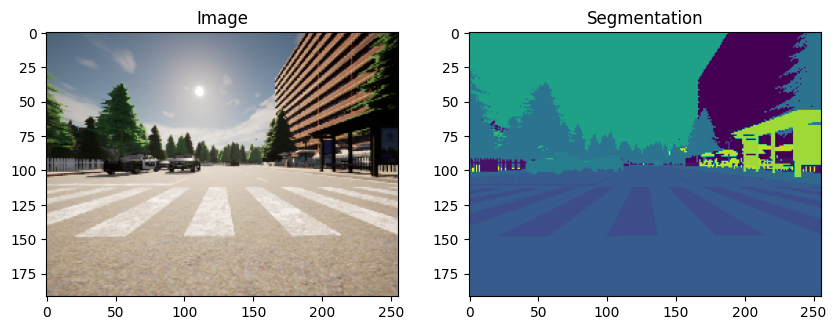

In [95]:
img = element[0].numpy()
mask = element[1].numpy()
fig, arr = plt.subplots(1, 2, figsize=(10, 7))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')
plt.show()

# <span style="color:green"> U-Net </span>
We build a U-Net which is inspired by the original U-Net article (Fig. 1 in [Ronneberger et al.](https://arxiv.org/abs/1505.04597)).

## Downsampling (encoder)
The downsampling part includes $4$ levels each with $2$ ($3\times 3$, *same* padding, ReLU activation) convolutional blocks. Number of filters on the upper level is N (e.g., 64 in the article) and doubles with each level. The output of each level goes through a maxpooling layer ($2\times2$, stride $s=2$) before being passed to the next level. Each level also makes a skip connection with an upsampling level with the same activation size (height and width). We also add a dopout option.

## Bottom level
This level is similar to the downsampling levels but without a maxpooling. It connects the downsampling and upsampling parts of the U-Net. The input activation (from upper level) is $\sim\left(\tfrac{n_H}{2^4},\tfrac{n_W}{2^4},8N\right)$, where $(n_H,n_W)$ denote the input image height and width. The ouput activation after two convolutional layers has the same height and width but $16N$ channels.

In [96]:
tfl = tf.keras.layers
def conv_block(inputs=None, n_filters=64, dropout_rate=0, max_pooling=True):
    """
    INPUT:
    inputs: input activation
    n_filters: int; number of filters for the convolutional layers
    dropout_rate: real; rate for the optional tfl.Dropout() layer
    max_pooling: boolean; True for downsampling levels, False for bottom level
    """
    conv = tfl.Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv = tfl.Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    
    if dropout_rate > 0:
        conv = tfl.Dropout(dropout_rate)(conv)
        
    if max_pooling:
        next_layer = tfl.MaxPooling2D()(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

## Upsampling (decoder)
Each upsampling level start with a $(3\times 3)$ transpose convolution of the previous layer to expand the height and width of the activation, and concatenation with the corresponding skip connection from the downsampling part. Then, it goes thorugh $2$ $(3\times 3)$ convolutional layers with *same* padding and ReLU activation. Number of filters equate to those of the corresponding downsampling levels doubling with levels going up.

In [97]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    INPUT:
    expansive_input: previous layer input
    contractive: skip connection input from the corresponding downsampling part
    n_filters: number of filters
    """    
    up = tfl.Conv2DTranspose(n_filters, 3, strides=2, padding='same')(expansive_input)
    merge = tfl.concatenate([up, contractive_input], axis=-1)
    conv = tfl.Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = tfl.Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    
    return conv

# Put things together

In [115]:
def unet_model(input_size=(384, 512, 3), n_filters=32, n_classes=23):
    """
    INPUT:
        input_size: Image input shape 
        n_filters: Number of filters for the convolutional layers at the first level
        n_classes: Number of output classes: car, building, ... 23 for CARLA self-driving car dataset
    OUTPUT: 
        model: tf.keras.Model
    """
    inputs = tfl.Input(input_size)
    # Downsampling part
    convBlock1 = conv_block(inputs, n_filters)
    convBlock2 = conv_block(convBlock1[0], 2*n_filters)
    convBlock3 = conv_block(convBlock2[0], 4*n_filters)
    convBlock4 = conv_block(convBlock3[0], 8*n_filters, dropout_rate=0.3)
    
    # Bottom level
    bottomLevel = conv_block(convBlock4[0], 16*n_filters, dropout_rate=0.3, max_pooling=False) 
    
    # Upsampling part
    uBlock4 = upsampling_block(bottomLevel[0], convBlock4[1], 8*n_filters)
    uBlock3 = upsampling_block(uBlock4, convBlock3[1], 4*n_filters)
    uBlock2 = upsampling_block(uBlock3, convBlock2[1], 2*n_filters)
    uBlock1 = upsampling_block(uBlock2, convBlock1[1], n_filters)

    extraConvLayer = tfl.Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(uBlock1)
    outputs = tfl.Conv2D(n_classes, 1, padding='same')(extraConvLayer)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [116]:
input_size = image_size+(3,)
unet = unet_model(input_size)
unet.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_312 (Conv2D)            (None, 192, 256, 32  896         ['input_28[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_313 (Conv2D)            (None, 192, 256, 32  9248        ['conv2d_312[0][0]']             
                                )                                                          

 conv2d_329 (Conv2D)            (None, 192, 256, 32  9248        ['conv2d_328[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_330 (Conv2D)            (None, 192, 256, 32  9248        ['conv2d_329[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_331 (Conv2D)            (None, 192, 256, 23  759         ['conv2d_330[0][0]']             
                                )                                                                 
                                                                                                  
Total params: 8,640,471
Trainable params: 8,640,471
Non-trainable params: 0
_________________________________

In [117]:
unet.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [118]:
numEpochs = 40
batchSize = 32
bufferSize = 500
train_ds = processed_image_ds.cache().shuffle(bufferSize).batch(batchSize)

In [119]:
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("myUNet.h5", monitor='accuracy', save_best_only=True),
]
history = unet.fit(train_ds, epochs=numEpochs, callbacks=my_callbacks)

Epoch 1/40
34/34 [==============================] - 298s 9s/step - loss: 2.5695 - accuracy: 0.3224
Epoch 2/40
34/34 [==============================] - 296s 9s/step - loss: 1.1780 - accuracy: 0.6786
Epoch 3/40
34/34 [==============================] - 295s 9s/step - loss: 0.7012 - accuracy: 0.8056
Epoch 4/40
34/34 [==============================] - 294s 9s/step - loss: 0.5506 - accuracy: 0.8380
Epoch 5/40
34/34 [==============================] - 294s 9s/step - loss: 0.4593 - accuracy: 0.8649
Epoch 6/40
34/34 [==============================] - 295s 9s/step - loss: 0.4072 - accuracy: 0.8791
Epoch 7/40
34/34 [==============================] - 294s 9s/step - loss: 0.3499 - accuracy: 0.8932
Epoch 8/40
34/34 [==============================] - 295s 9s/step - loss: 0.3587 - accuracy: 0.8956
Epoch 9/40
34/34 [==============================] - 295s 9s/step - loss: 0.2951 - accuracy: 0.9127
Epoch 10/40
34/34 [==============================] - 295s 9s/step - loss: 0.2542 - accuracy: 0.9237
Epoch 11/

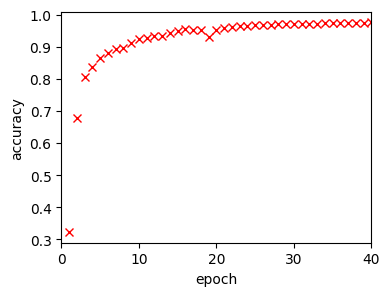

In [135]:
import numpy as np
plt.figure(figsize=(4,3))
plt.plot(1+np.arange(numEpochs),history.history["accuracy"],'xr')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim((0,40))
plt.show()

# <span style="color:green"> Evaluation </span>

In [144]:
unet.trainable = False

In [ ]:
element = next(iter(train_ds))
images, masks = element
predictions = tf.math.argmax(unet.predict(images),axis=-1)

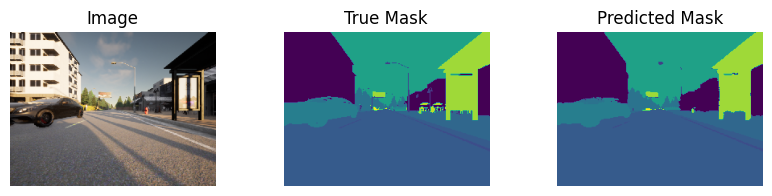

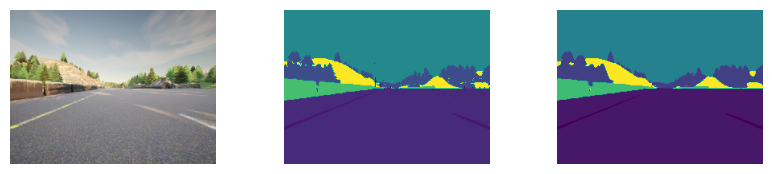

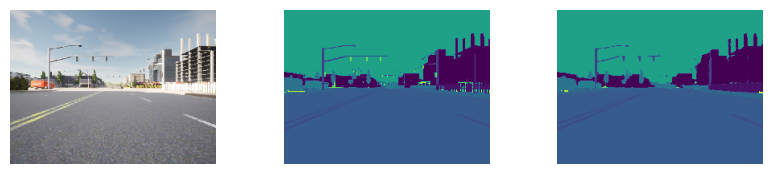

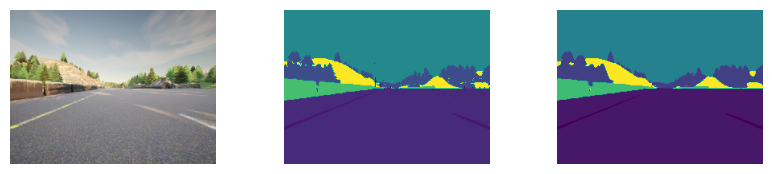

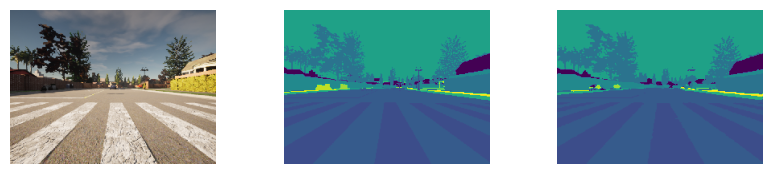

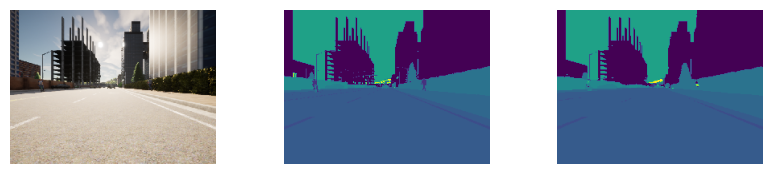

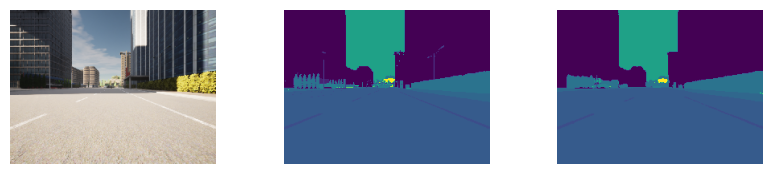

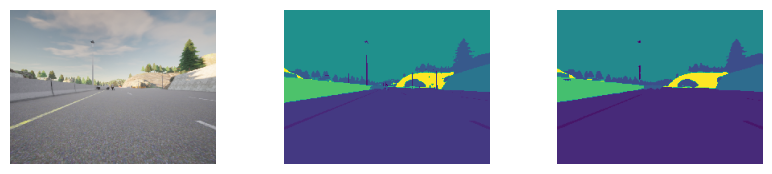

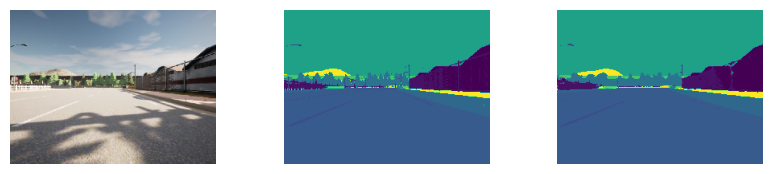

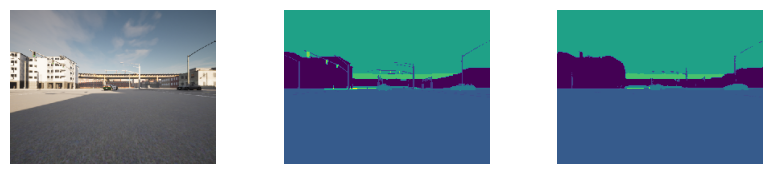

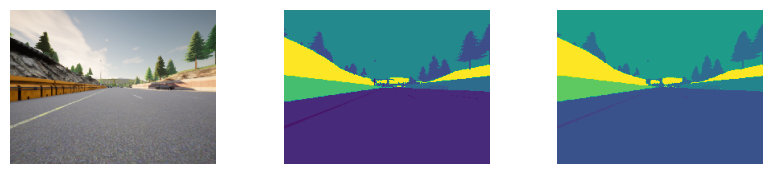

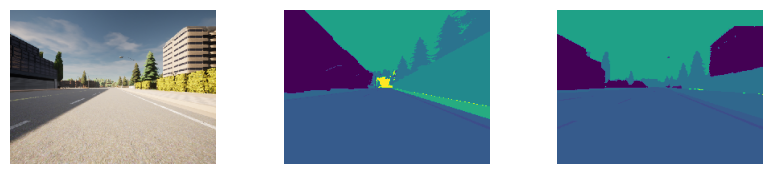

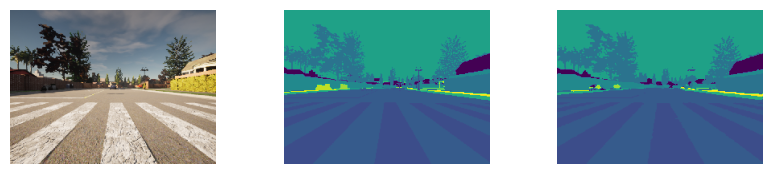

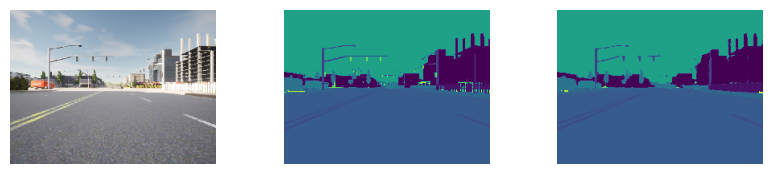

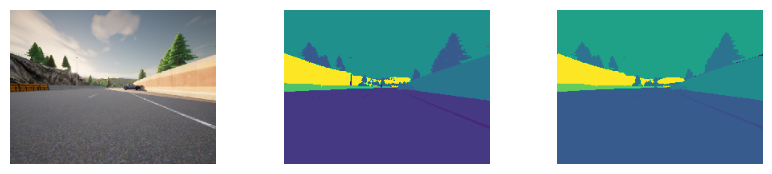

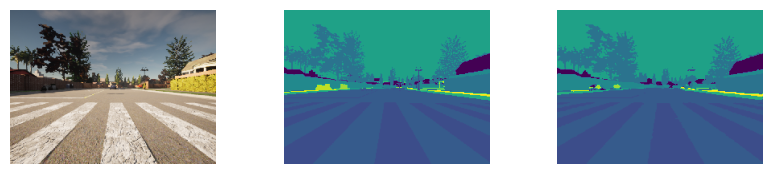

In [183]:
N = 16
for i in range(N):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 2))
    random_index = np.random.randint(batchSize)
    ax[0].imshow(images[random_index])
    ax[1].imshow(masks[random_index])
    ax[2].imshow(predictions[random_index])
    for a in ax:
        a.set_axis_off()
    if i == 0:
        ax[0].set_title('Image')
        ax[1].set_title('True Mask')
        ax[2].set_title('Predicted Mask')

plt.show()